In [385]:
# Run this cell to set up your notebook. 
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import ast
from pathlib import Path

# Pandas display configuration
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100

# Default plot configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

from IPython.display import display, Latex, Markdown


In [290]:
# Unzip files
data_dir = Path('data')
zipped_data = zipfile.ZipFile('data/test.csv.zip', 'r')
zipped_data.extractall(data_dir)
zipped_data = zipfile.ZipFile('data/train.csv.zip', 'r')
zipped_data.extractall(data_dir)
zipped_data = zipfile.ZipFile('data/sample_submission.csv.zip', 'r')
zipped_data.extractall(data_dir)

In [291]:
# Read data to Pandas dataframe
train = pd.read_csv(data_dir/'train.csv', low_memory=False)
test = pd.read_csv(data_dir/'test.csv', low_memory=False)

In [292]:
len(train), train.columns, train.dtypes

(903653,
 Index(['channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork',
        'sessionId', 'socialEngagementType', 'totals', 'trafficSource',
        'visitId', 'visitNumber', 'visitStartTime'],
       dtype='object'),
 channelGrouping         object
 date                     int64
 device                  object
 fullVisitorId           object
 geoNetwork              object
 sessionId               object
 socialEngagementType    object
 totals                  object
 trafficSource           object
 visitId                  int64
 visitNumber              int64
 visitStartTime           int64
 dtype: object)

In [296]:
# Downsample for training speed
# df = train[0:100000]
df = train.copy()

In [293]:
# Given a Series of json strings records, returns a dataframe
def json_to_df(series):
    col = list(series)
    s = '['+', '.join(col)+']'
    return pd.read_json(s, orient='records')

In [297]:
# Transform each aggregate column into a separate dataframe
totals = json_to_df(df['totals'])
print(totals.dtypes)
geonetwork = json_to_df(df['geoNetwork'])
print(geonetwork.dtypes)
device = json_to_df(df['device'])
print(device.dtypes)
trafficsource = json_to_df(df['trafficSource'])
print(trafficsource.dtypes)

bounces               float64
hits                    int64
newVisits             float64
pageviews             float64
transactionRevenue    float64
visits                  int64
dtype: object
city               object
cityId             object
continent          object
country            object
latitude           object
longitude          object
metro              object
networkDomain      object
networkLocation    object
region             object
subContinent       object
dtype: object
browser                      object
browserSize                  object
browserVersion               object
deviceCategory               object
flashVersion                 object
isMobile                       bool
language                     object
mobileDeviceBranding         object
mobileDeviceInfo             object
mobileDeviceMarketingName    object
mobileDeviceModel            object
mobileInputSelector          object
operatingSystem              object
operatingSystemVersion       object
sc

In [298]:
# Drop all of the aggregate columns and replace them with expanded columns
df.drop(['totals', 'geoNetwork', 'device', 'trafficSource'], axis=1, inplace=True)
df = df.join([totals, geonetwork, device, trafficsource])

In [299]:
# How sparse is the data? Which are the sparse columns
print((df.isna().sum(axis=0)/len(df)).sort_values(ascending=False))

campaignCode                 0.999999
adContent                    0.987887
transactionRevenue           0.987257
isTrueDirect                 0.696781
referralPath                 0.633774
keyword                      0.556551
bounces                      0.501324
newVisits                    0.221980
pageviews                    0.000111
longitude                    0.000000
latitude                     0.000000
country                      0.000000
continent                    0.000000
cityId                       0.000000
city                         0.000000
visits                       0.000000
source                       0.000000
hits                         0.000000
networkDomain                0.000000
visitStartTime               0.000000
visitNumber                  0.000000
visitId                      0.000000
socialEngagementType         0.000000
sessionId                    0.000000
fullVisitorId                0.000000
date                         0.000000
metro       

In [302]:
# How many unique visitors are there? 714K
df.fullVisitorId.nunique()

714167

In [379]:
# Distribution of visits per visitor?
visitor_count = df.fullVisitorId.value_counts()
visitor_count.sort_values(inplace=True, ascending=False)
display(visitor_count.head(5))
visitor_count_distribution = visitor_count.groupby(visitor_count).size()
visitor_count_distribution.head(10)

1957458976293878100    278
0824839726118485274    255
3608475193341679870    201
1856749147915772585    199
3269834865385146569    155
Name: fullVisitorId, dtype: int64

fullVisitorId
1     620675
2      58711
3      17159
4       7400
5       3633
6       2065
7       1231
8        838
9        538
10       384
Name: fullVisitorId, dtype: int64

In [358]:
# 98.6% of users have visited less than 5 times; 87% of visitors visit just once
display((visitor_count_distribution/visitor_count_distribution.sum()).head(4))
(visitor_count_distribution/visitor_count_distribution.sum()).head(4).sum()

fullVisitorId
1    0.869089
2    0.082209
3    0.024027
4    0.010362
Name: fullVisitorId, dtype: float64

0.9856868211496752

In [376]:
# 10K visitors have visited 5 or more times
visitor_count_distribution[4:].sum()

10222

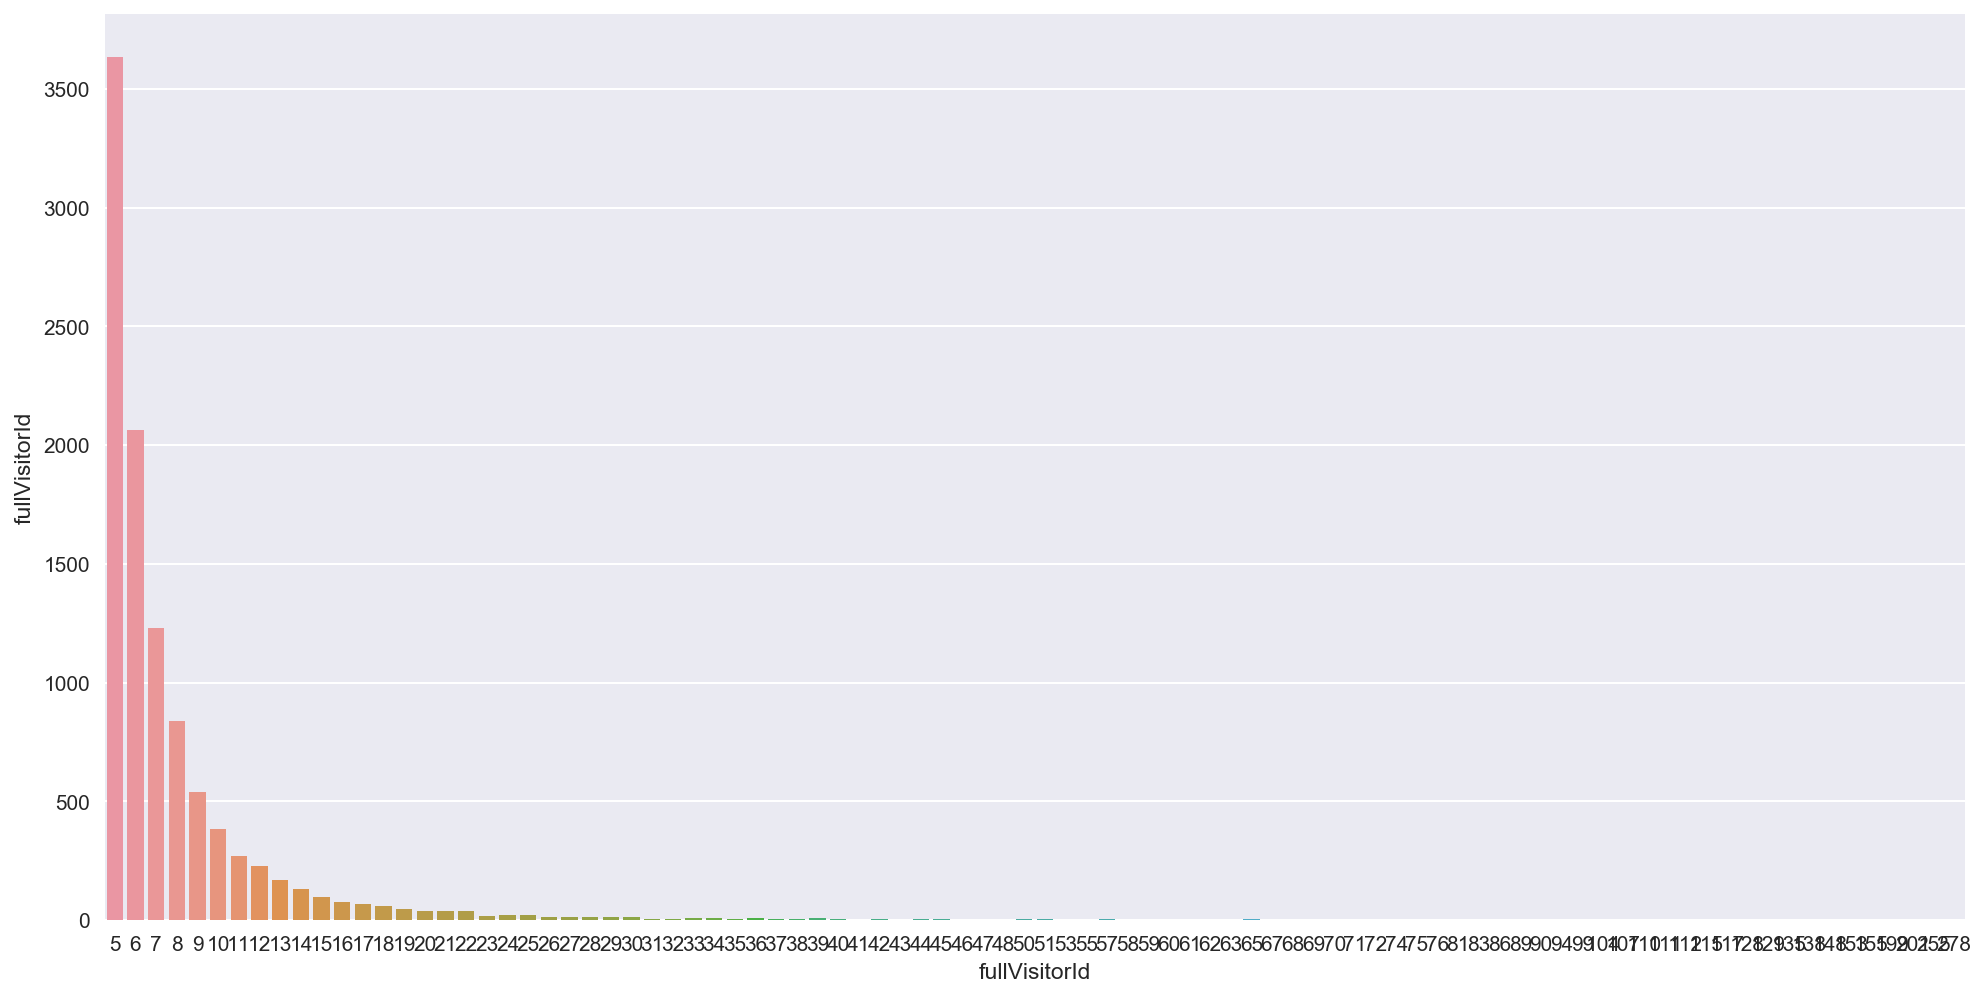

In [355]:
# Histogram of visitor count by # of visits 
# (i.e. 3500+ ppl visited 5 times, 2000+ ppl visited 6 times, ~1250 ppl visited 7 times)

i = 5
index = visitor_count_distribution.index
sns.barplot(x=index[i-1:],y=visitor_count_distribution[i-1:])

In [474]:
# What do the most frequenty visitors look like?
vip = visitor_count.index[:100]
display(vip[:10])
display(df[df['fullVisitorId']==vip[0]].head())
display(df[df['fullVisitorId']==vip[1]].head())

Index(['1957458976293878100', '0824839726118485274', '3608475193341679870',
       '1856749147915772585', '3269834865385146569', '0720311197761340948',
       '7634897085866546110', '4038076683036146727', '0232377434237234751',
       '3694234028523165868'],
      dtype='object')

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,bounces,hits,newVisits,pageviews,transactionRevenue,visits,city,cityId,continent,country,latitude,longitude,metro,networkDomain,networkLocation,region,subContinent,browser,browserSize,browserVersion,deviceCategory,flashVersion,isMobile,language,mobileDeviceBranding,mobileDeviceInfo,mobileDeviceMarketingName,mobileDeviceModel,mobileInputSelector,operatingSystem,operatingSystemVersion,screenColors,screenResolution,adContent,adwordsClickInfo,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source
921,Organic Search,20160902,1957458976293878100,1957458976293878100_1472841771,Not Socially Engaged,1472841771,85,1472841771,NaN,22,NaN,16.0,NaN,1,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,comcastbusiness.net,not available in demo dataset,not available in demo dataset,Northern America,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,NaN,{'criteriaParameters': 'not available in demo dataset'},(not set),NaN,1.0,(not provided),organic,NaN,google
1645,Organic Search,20160902,1957458976293878100,1957458976293878100_1472821703,Not Socially Engaged,1472821703,83,1472821703,NaN,3,NaN,3.0,NaN,1,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,comcastbusiness.net,not available in demo dataset,not available in demo dataset,Northern America,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,NaN,{'criteriaParameters': 'not available in demo dataset'},(not set),NaN,1.0,(not provided),organic,NaN,google
1666,Organic Search,20160902,1957458976293878100,1957458976293878100_1472823804,Not Socially Engaged,1472823804,84,1472823804,NaN,5,NaN,5.0,NaN,1,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,comcastbusiness.net,not available in demo dataset,not available in demo dataset,Northern America,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,NaN,{'criteriaParameters': 'not available in demo dataset'},(not set),NaN,1.0,(not provided),organic,NaN,google
4366,Organic Search,20170126,1957458976293878100,1957458976293878100_1485444781,Not Socially Engaged,1485444781,178,1485444781,NaN,3,NaN,3.0,NaN,1,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,Northern America,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available i

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,bounces,hits,newVisits,pageviews,transactionRevenue,visits,city,cityId,continent,country,latitude,longitude,metro,networkDomain,networkLocation,region,subContinent,browser,browserSize,browserVersion,deviceCategory,flashVersion,isMobile,language,mobileDeviceBranding,mobileDeviceInfo,mobileDeviceMarketingName,mobileDeviceModel,mobileInputSelector,operatingSystem,operatingSystemVersion,screenColors,screenResolution,adContent,adwordsClickInfo,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source
4812,Organic Search,20170126,0824839726118485274,0824839726118485274_1485441650,Not Socially Engaged,1485441650,317,1485441650,NaN,3,NaN,3.0,NaN,1,Salem,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,Roanoke-Lynchburg VA,comcast.net,not available in demo dataset,Virginia,Northern America,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,NaN,{'criteriaParameters': 'not available in demo dataset'},(not set),NaN,1.0,(not provided),organic,NaN,google
15030,Organic Search,20170613,0824839726118485274,0824839726118485274_1497375008,Not Socially Engaged,1497375008,389,1497375008,NaN,2,NaN,2.0,NaN,1,Salem,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,Roanoke-Lynchburg VA,sl-reverse.com,not available in demo dataset,Virginia,Northern America,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,NaN,{'criteriaParameters': 'not available in demo dataset'},(not set),NaN,1.0,(not provided),organic,NaN,google
20974,Organic Search,20161118,0824839726118485274,0824839726118485274_1479500622,Not Socially Engaged,1479500622,245,1479500622,NaN,4,NaN,4.0,NaN,1,Salem,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,Roanoke-Lynchburg VA,comcast.net,not available in demo dataset,Virginia,Northern America,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,NaN,{'criteriaParameters': 'not available in demo dataset'},(not set),NaN,1.0,(not provided),organic,NaN,google
22274,Organic Search,20161110,0824839726118485274,0824839726118485274_1478792255,Not Socially Engaged,1478792255,235,1478792255,NaN,12,NaN,8.0,NaN,1,Salem,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,Roanoke-Lynchburg VA,comcast.net,not available in demo dataset,Virginia,Northern America,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,NaN,{'criteriaParameters': 'not available in demo dataset'},(not s

In [412]:
# Creating a rev Series that is indexed by fullVisitorId and contains ln(sum of all transactionRevenue+1)
# Note that the competition organizers want to predict log revenue
raw_rev = df['transactionRevenue'].groupby(df['fullVisitorId']).sum().sort_values(ascending=False)
rev = np.log(raw_rev+1)
rev[:5]

fullVisitorId
1957458976293878100    25.068543
5632276788326171571    23.497338
9417857471295131045    23.442594
4471415710206918415    23.140170
4984366501121503466    22.976020
Name: transactionRevenue, dtype: float64

In [471]:
# Top 90K visitors (by visit count) account for 68% of total revenue
vip = visitor_count.index[:90000]
display(rev[vip[:10]])
print(np.mean(rev[vip]), np.sum(rev[vip]), np.sum(rev[vip])/np.sum(rev))

1957458976293878100    25.068543
0824839726118485274     0.000000
3608475193341679870    16.971660
1856749147915772585     0.000000
3269834865385146569    19.007912
0720311197761340948     0.000000
7634897085866546110    17.034386
4038076683036146727     0.000000
0232377434237234751    16.704771
3694234028523165868    16.536148
Name: transactionRevenue, dtype: float64

1.346440073019153 121179.60657172407 0.6799653929729056


In [472]:
# Remaining 600K+ visitors account for ONLY ~32% of total revenue
print(np.mean(rev[~rev.index.isin(vip)]), np.sum(rev[~rev.index.isin(vip)]), np.sum(rev[~rev.index.isin(vip)])/np.sum(rev))

0.09137741504843964 57034.76701853998 0.32003460702709463


/Users/shinkim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


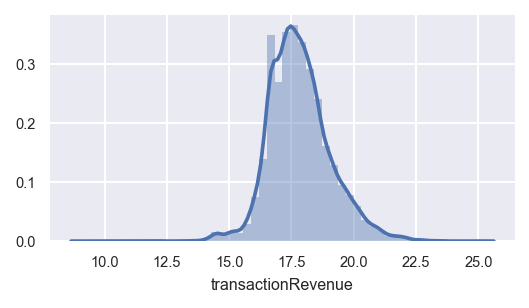

In [492]:
# Distribution of Revenue
sns.set(font_scale=0.7)
plt.figure(figsize=(4,2))
pos_rev = rev[rev>0]
sns.distplot(pos_rev)

In [458]:
# Total Revenue
rev.sum()

178214.373590264

In [476]:
# How many times have the top customers visited
visitor_count[rev.index[:10]]

fullVisitorId
1957458976293878100    278
5632276788326171571      6
9417857471295131045     16
4471415710206918415     34
4984366501121503466     24
9089132392240687728     22
9029794295932939024     22
7463172420271311409     16
7311242886083854158     26
79204932396995037        8
Name: fullVisitorId, dtype: int64

In [478]:
# Customers who have made any purchse (i.e. rev>0) have visited 3.6 times on average
np.mean(visitor_count[rev[rev>0].index])

3.6124449779911965

In [480]:
# The average customer (including those who did not purchase) has visited 1.3 times
np.mean(visitor_count)

1.26532449693139